In [0]:
!pip install nltk
!pip install unidecode

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import unidecode
import csv
import nltk
from string import punctuation
from wordcloud import WordCloud
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer


nltk.download('all')

df_resenha = pd.read_csv('imdb-reviews-pt-br.csv')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

# Alterar a tipagem do target

In [0]:
target = df_resenha['sentiment'].replace(['neg','pos'],[0,1])

In [0]:
df_resenha['target'] = target

# Modelo de classificação utlizando Regressão Logistica

In [0]:
def rank_text(text, column_text, column_classification):

    vectorizer = TfidfVectorizer(lowercase = False, ngram_range = (1,2))
    bag_of_words = vectorizer.fit_transform(text[column_text])
    x_train, x_test, y_train, y_test = train_test_split(bag_of_words,
                                                        text[column_classification],
                                                        random_state=42)
    model = LogisticRegression(solver = 'lbfgs')
    model.fit(x_train, y_train)
    return model.score(x_test, y_test) 

# Nuvem de palavras negativas

In [0]:
def word_cloud_neg(text, column_text):
  
    text_neg = text.query('sentiment == "neg"')
    word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations= False
                          ).generate(' '.join([text for text in text_neg[column_text]]))

    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

# Nuvem de palavras positivas

In [0]:
def word_cloud_pos(text, column_text):
  
    text_pos = text.query('sentiment == "pos"')
    word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110, collocations= False
                          ).generate(' '.join([text for text in text_pos[column_text]]))

    plt.figure(figsize=(10,7))
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

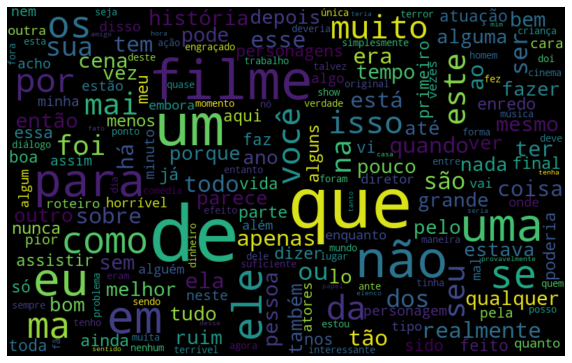

In [0]:
word_cloud_neg(df_resenha,'text_pt')

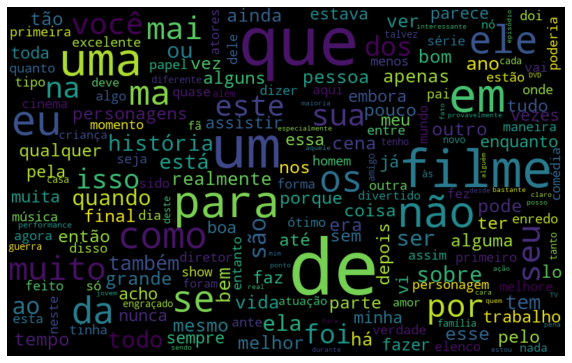

In [0]:
word_cloud_pos(df_resenha,'text_pt')

# Aplicando o grafico de Pareto
Aplicando esse gráfico é póssivel ver as palavras que aparecem com mais frequencias, usados para por exemplo mostrar possíveis stopwords

In [0]:
def show_frequency_words(text, column_text, number_of_words):

    token_space =  tokenize.WhitespaceTokenizer()
    token_phrase = token_space.tokenize(' '.join([text for text in text[column_text]]))
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({'Word': list(frequency.keys()),
                                'Frequency': list(frequency.values())})
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency.nlargest(columns = 'Frequency', n = number_of_words), x = 'Word', y = 'Frequency', color = 'gray')
    ax.set(ylabel = 'Count')
    plt.show()

# Transformando as frases em listas de palavras separadas por espaços em branco

In [0]:
stop_words = nltk.corpus.stopwords.words('portuguese')
token_space =  tokenize.WhitespaceTokenizer()
processed_phrase = list()
for op in df_resenha.text_pt:
    new_phrase = list()
    word_text = token_space.tokenize(op)
    for word in word_text:
       if word not in stop_words:
         new_phrase.append(word)
    processed_phrase.append(' '.join(new_phrase))

df_resenha['treatment_1'] = processed_phrase

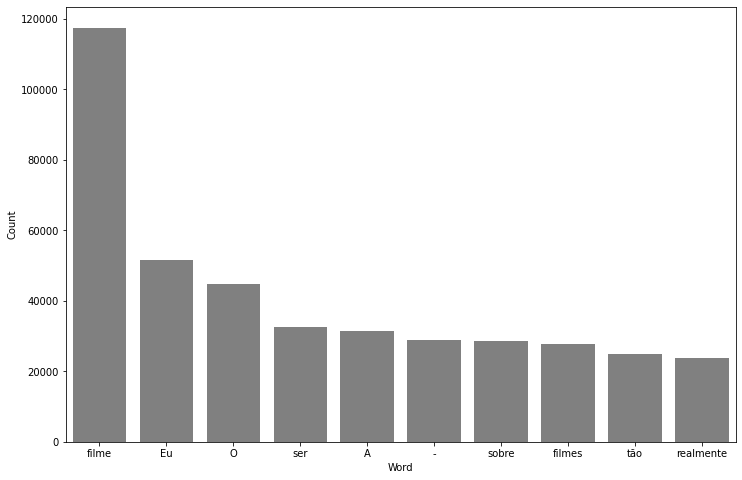

In [0]:
show_frequency_words(df_resenha, 'treatment_1', 10)

In [0]:
rank_text(df_resenha,'treatment_1','target')

0.6640517589971694

# Removendo a Pontuação

In [0]:
token_punctuation = tokenize.WordPunctTokenizer()
list_punctuation = list()
for punct in punctuation:
    list_punctuation.append(punct)

punct_stopwords = list_punctuation + stop_words
processed_phrase = list()
for op in df_resenha['treatment_1']:
    new_phrase = list()
    text_word = token_punctuation.tokenize(op)
    for word in text_word:
        if word not in punct_stopwords:
            new_phrase.append(word)
    processed_phrase.append(' '.join(new_phrase))

df_resenha['treatment_2'] = processed_phrase

# Removendo as acentuações das palavras

In [0]:
whiout_accent = [unidecode.unidecode(x) for x in df_resenha.treatment_2 ]

In [0]:
stopwords_whiout_accent = [unidecode.unidecode(x) for x in punct_stopwords]

In [0]:
df_resenha['treatment_3'] = whiout_accent
processed_phrase = list()
for op in df_resenha['treatment_3']:
    new_phrase = list()
    text_word = token_punctuation.tokenize(op)
    for word in text_word:
        if word not in stopwords_whiout_accent:
            new_phrase.append(word)
    processed_phrase.append(' '.join(new_phrase))

df_resenha['treatment_3'] = processed_phrase

# Transformando as palavras em minusculas e removento novamente as stopwords
Algumas palavras pode ser que sejam vistas diferente por estarem em maiusculas

In [0]:
processed_phrase = list()
for op in df_resenha['treatment_3']:
    new_phrase = list()
    op = op.lower()
    text_word = token_punctuation.tokenize(op)
    for word in text_word:
        if word not in stopwords_whiout_accent:
            new_phrase.append(word)
    processed_phrase.append(' '.join(new_phrase))

df_resenha['treatment_4'] = processed_phrase

In [0]:
rank_text(df_resenha,'treatment_4','target')

0.6879094217549535

# Aplicando o Stemmer
Ao aplicar o stemmer as palavras serão reduzidas, por exemplo "correlacao" se transformaria em "corr"

In [0]:
stemmer = nltk.RSLPStemmer()
processed_phrase = list()
for op in df_resenha['treatment_4']:
    new_phrase = list()
    op = op.lower()
    text_word = token_punctuation.tokenize(op)
    for word in text_word:
        if word not in stopwords_whiout_accent:
            new_phrase.append(stemmer.stem(word))
    processed_phrase.append(' '.join(new_phrase))

df_resenha['treatment_5'] = processed_phrase

In [0]:
rank_text(df_resenha, 'treatment_5', 'target')

0.8858875859280226